In [1]:
from notebooks.util.distribution_utils import *
from liquidity.features import compute_aggregate_features

from market_impact.util.utils import normalize_imbalances

from hurst_exponent.util.utils import augmented_dickey_fuller

In [2]:
# Automatically reload changes in package dependencies
%load_ext autoreload
%autoreload 2

In [3]:
# Number of events to use
EVENTS_RANGE = 500000

# Bin/window size for computing events
T = 1000

## Load market orders raw sample data

In [4]:
# Load orderbook raw sample data
stocks = ['TSLA', 'AMZN', 'NFLX', 'MSFT', 'EBAY', 'AAPL']

current_dir = os.path.abspath('.')
root_dir = os.path.join(current_dir, '..', '..')
data_dir = os.path.join(root_dir, 'data', 'market_orders')

stock_dfs = {}

# Loop through each stock
for stock in stocks:

    filename = f"{stock}-2017-NEW.csv"

    stock_file_path = os.path.join(data_dir, filename)

    # Read the CSV and store in the dictionary
    stock_dfs[stock] = pd.read_csv(stock_file_path)

# Access the dataframe using stock's ticker as key
tsla_raw_df = stock_dfs['TSLA']
amzn_raw_df = stock_dfs['AMZN']
nflx_raw_df = stock_dfs['NFLX']
msft_raw_df = stock_dfs['MSFT']
ebay_raw_df = stock_dfs['EBAY']
appl_raw_df = stock_dfs['AAPL']

In [5]:
tsla_raw_df

,Unnamed: 0,event_timestamp,sign,side,lob_action,order_executed,execution_price,size,ask,bid,...,bid_queue_size_mean,midprice_change,R1,spread,date,daily_R1,daily_vol,daily_num,norm_size,signed_volume
0,0,2017-01-03 10:30:19.351489154,1,ASK,UPDATE,True,219.37,1,219.37,219.28,...,135.963741,0.000,0.000,0.09,2017-01-03,0.021159,277786,3279,0.008043,1
1,1,2017-01-03 10:30:19.351537884,1,ASK,REMOVE,True,219.37,15,219.37,219.28,...,135.963741,0.005,0.005,0.09,2017-01-03,0.021159,277786,3279,0.120647,15
2,2,2017-01-03 10:30:19.351549791,1,ASK,UPDATE,True,219.38,80,219.38,219.28,...,135.963741,0.005,0.005,0.10,2017-01-03,0.021159,277786,3279,0.643452,80
3,3,2017-01-03 10:30:19.351601187,1,ASK,UPDATE,True,219.38,80,219.38,219.29,...,135.963741,0.000,0.000,0.09,2017-01-03,0.021159,277786,3279,0.643452,80
4,4,2017-01-03 10:30:19.351702603,1,ASK,REMOVE,True,219.38,40,219.38,219.29,...,135.963741,0.050,0.050,0.09,2017-01-03,0.021159,277786,3279,0.321726,40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1411991,3572,2017-12-29 14:59:11.533706465,1,ASK,REMOVE,True,311.06,321,311.06,311.02,...,151.020334,0.025,0.025,0.04,2017-12-29,0.019713,322243,3577,2.112474,321
1411992,3573,2017-12-29 14:59:50.386983509,-1,BID,REMOVE,True,311.03,200,311.10,311.03,...,151.020334,-0.030,0.030,0.07,2017-12-29,0.019713,322243,3577,1.324325,-200
1411993,3574,2017-12-29 14:59:50.387892067,-1,BID,UPDATE,True,311.02,200,311.05,311.02,...,151.020334,0.000,-0.000,0.03,2017-12-29,0.019713,322243,3577,1.324325,-200
1411994,3575,2017-12-29 14:59:50.387904347,-1,BID,UPDATE,True,311.02,2,311.05,311.02,...,151.020334,0.000,-0.000,0.03,2017-12-29,0.019713,322243,3577,0.013243,-2


## 1. Orderflow

### 1.1. Size/ Volume

In [6]:
# Order size/ volume
size_volume = {'TSLA': tsla_raw_df['norm_size'],
               'MSFT': amzn_raw_df['norm_size'],
               'AMZN': nflx_raw_df['norm_size'],
               'NFLX': msft_raw_df['norm_size'],
               'EBAY': ebay_raw_df['norm_size'],
               'AAPL': appl_raw_df['norm_size'],
               }

# Order signed volume
signed_volume = {'TSLA': tsla_raw_df['signed_volume'],
               'MSFT': amzn_raw_df['signed_volume'],
               'AMZN': nflx_raw_df['signed_volume'],
               'NFLX': msft_raw_df['signed_volume'],
               'EBAY': ebay_raw_df['signed_volume'],
               'AAPL': appl_raw_df['signed_volume'],
               }
# Update the dictionary to only keep the first EVENTS_RANGE items
#size_volume = {stock: data.head(EVENTS_RANGE) for stock, data in size_volume.items()}

#### Stationarity Test

In [7]:
# ADF test
for stock, data in size_volume.items():
    augmented_dickey_fuller(data.head(EVENTS_RANGE), stock)

TSLA
ADF: -64.49
p-value: 0.00,
N: 499911, 
critical values: {'1%': -3.4303630809955736, '5%': -2.8615457816460723, '10%': -2.566773077359008}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


MSFT
ADF: -57.33
p-value: 0.00,
N: 499899, 
critical values: {'1%': -3.4303630813095825, '5%': -2.8615457817848604, '10%': -2.5667730774328796}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


AMZN
ADF: -59.95
p-value: 0.00,
N: 499899, 
critical values: {'1%': -3.4303630813095825, '5%': -2.8615457817848604, '10%': -2.5667730774328796}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


NFLX
ADF: -46.07
p-value: 0.00,
N: 499898, 
critical values: {'1%': -3.4303630813357504, '5%': -2.8615457817964263, '10%': -2.566773077439036}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


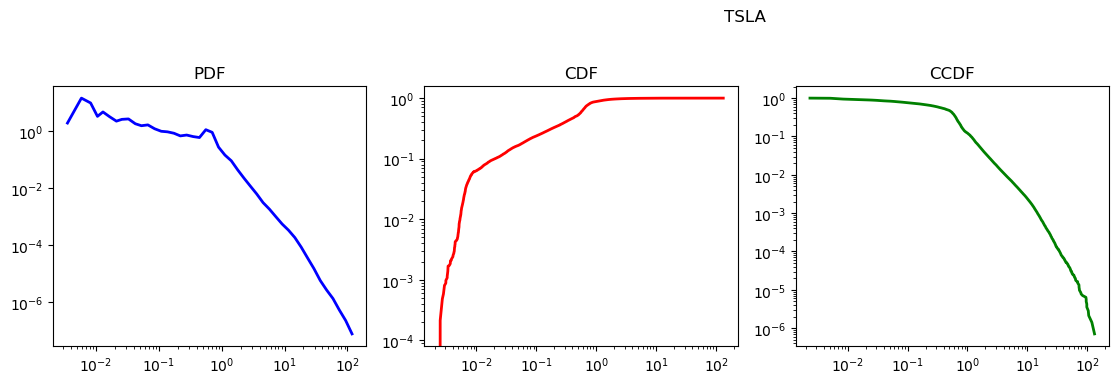

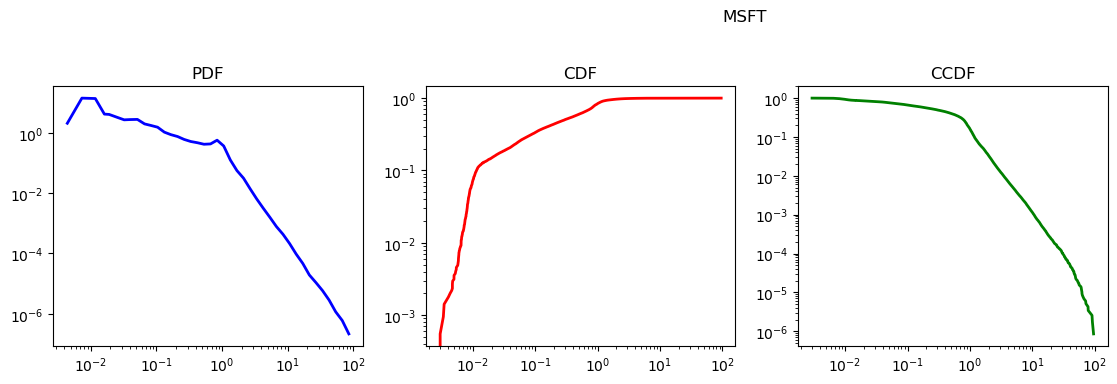

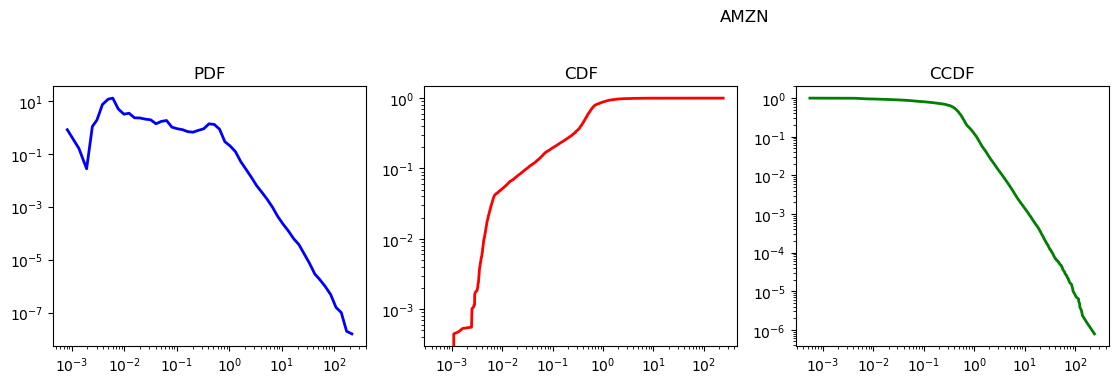

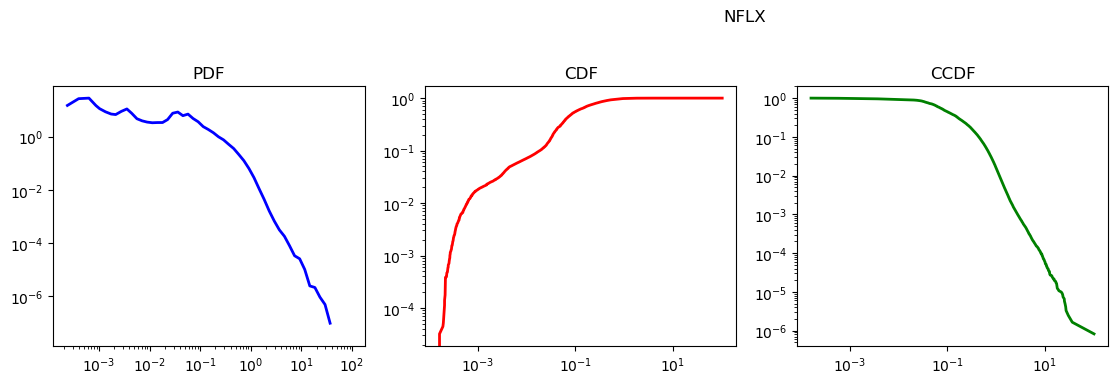

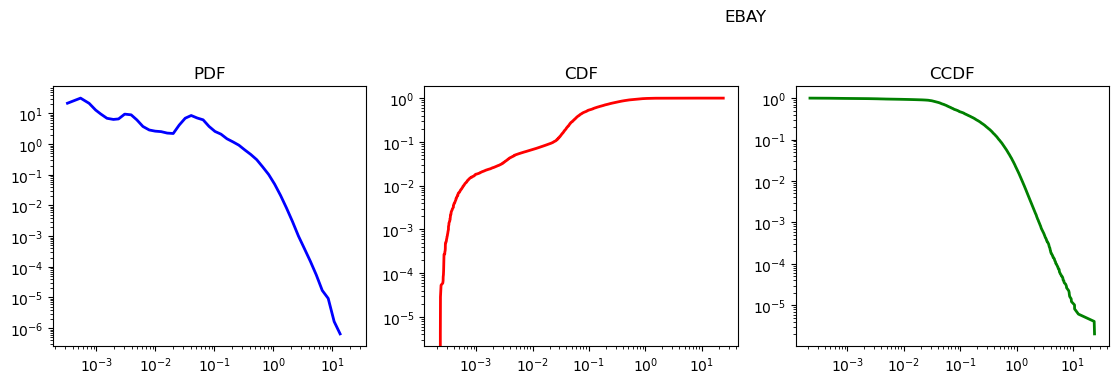

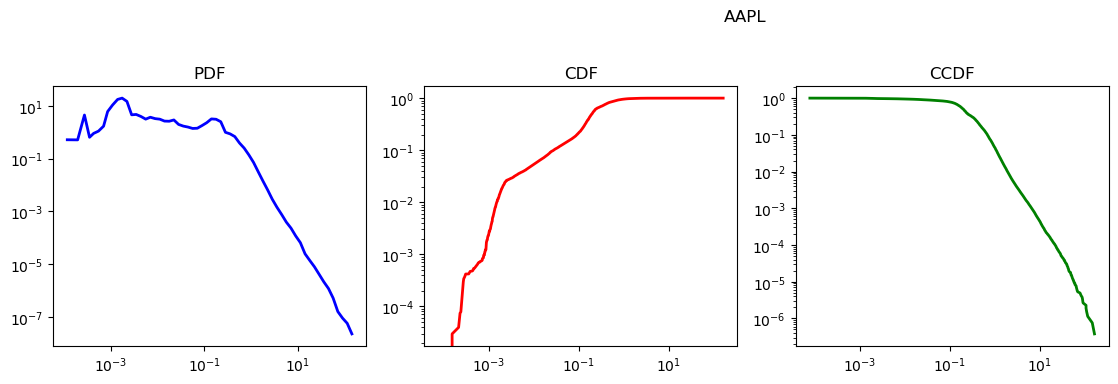

In [8]:
# Plot distribution of size_volume for each stock
for stock_name, data in size_volume.items():
    plot_distributions(stock_name, data)

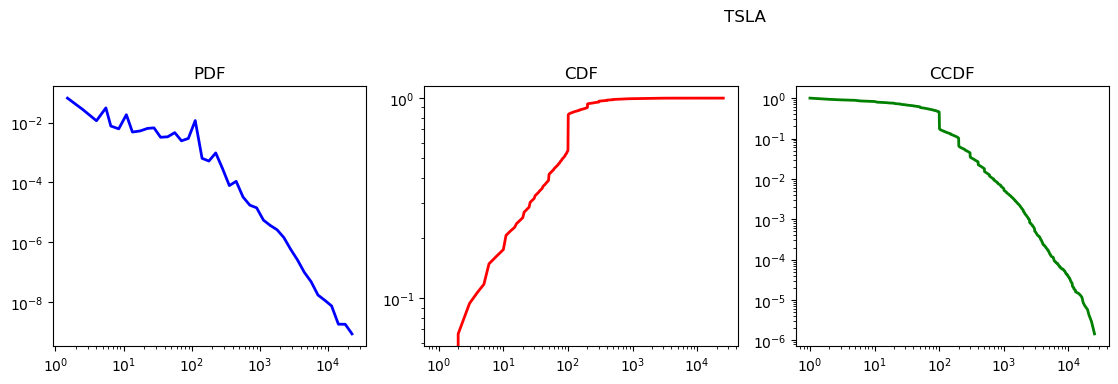

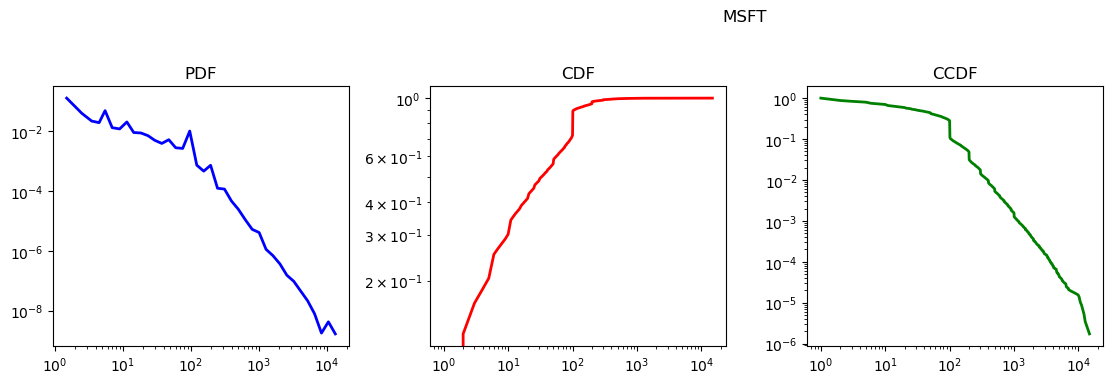

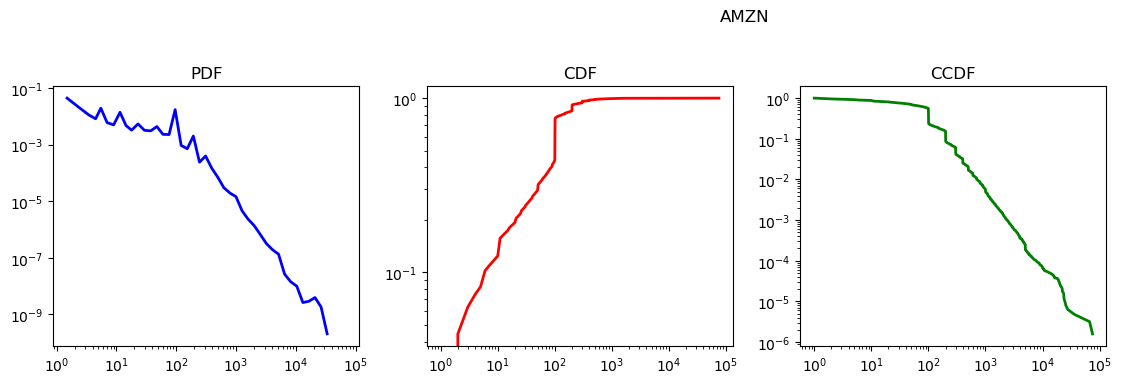

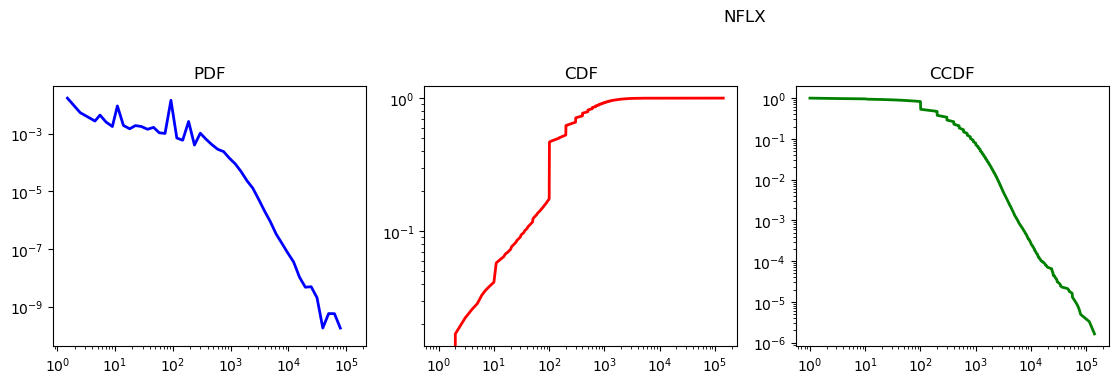

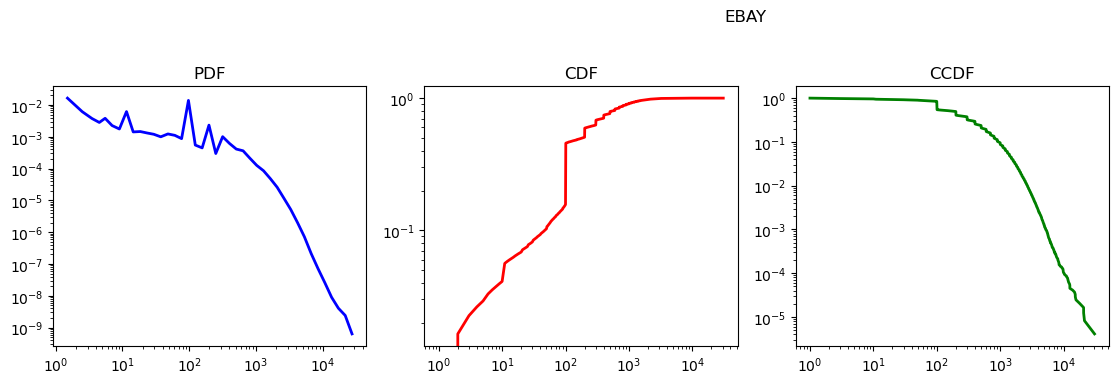

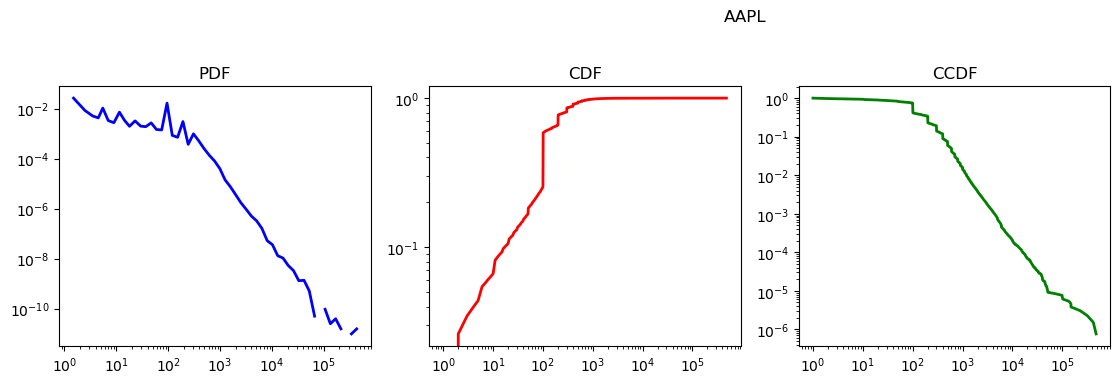

In [9]:
# Plot distribution of size_volume for each stock
for stock_name, data in signed_volume.items():
    plot_distributions(stock_name, data)

### 1.2. Fit power law distribution

In [10]:
# 1. Fit Powerlaw and retrieve fitted object/ results
size_volume_data = os.path.join(root_dir, 'data', 'generated', 'mo_data', 'distributions', 'mo_signed_volume_distributions.pkl')

# If the file doesn't exist, fit the series and save the results.
if not os.path.exists(size_volume_data):
    volume_fit_objects = fit_powerlaw(data_dict=signed_volume, filename=size_volume_data)
else:
    volume_fit_objects = load_fit_objects(size_volume_data)

volume_fit_objects

{'TSLA': <powerlaw.Fit at 0x14da83490>,
 'MSFT': <powerlaw.Fit at 0x17784b150>,
 'AMZN': <powerlaw.Fit at 0x1672bbbd0>,
 'NFLX': <powerlaw.Fit at 0x17793aa50>,
 'EBAY': <powerlaw.Fit at 0x14da7e590>,
 'AAPL': <powerlaw.Fit at 0x14d907110>}

/Users/ana_bugaenko/.conda/envs/py311/lib/python3.11/site-packages/powerlaw.py:1615: RuntimeWarning: invalid value encountered in divide
  CDF = CDF/norm
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


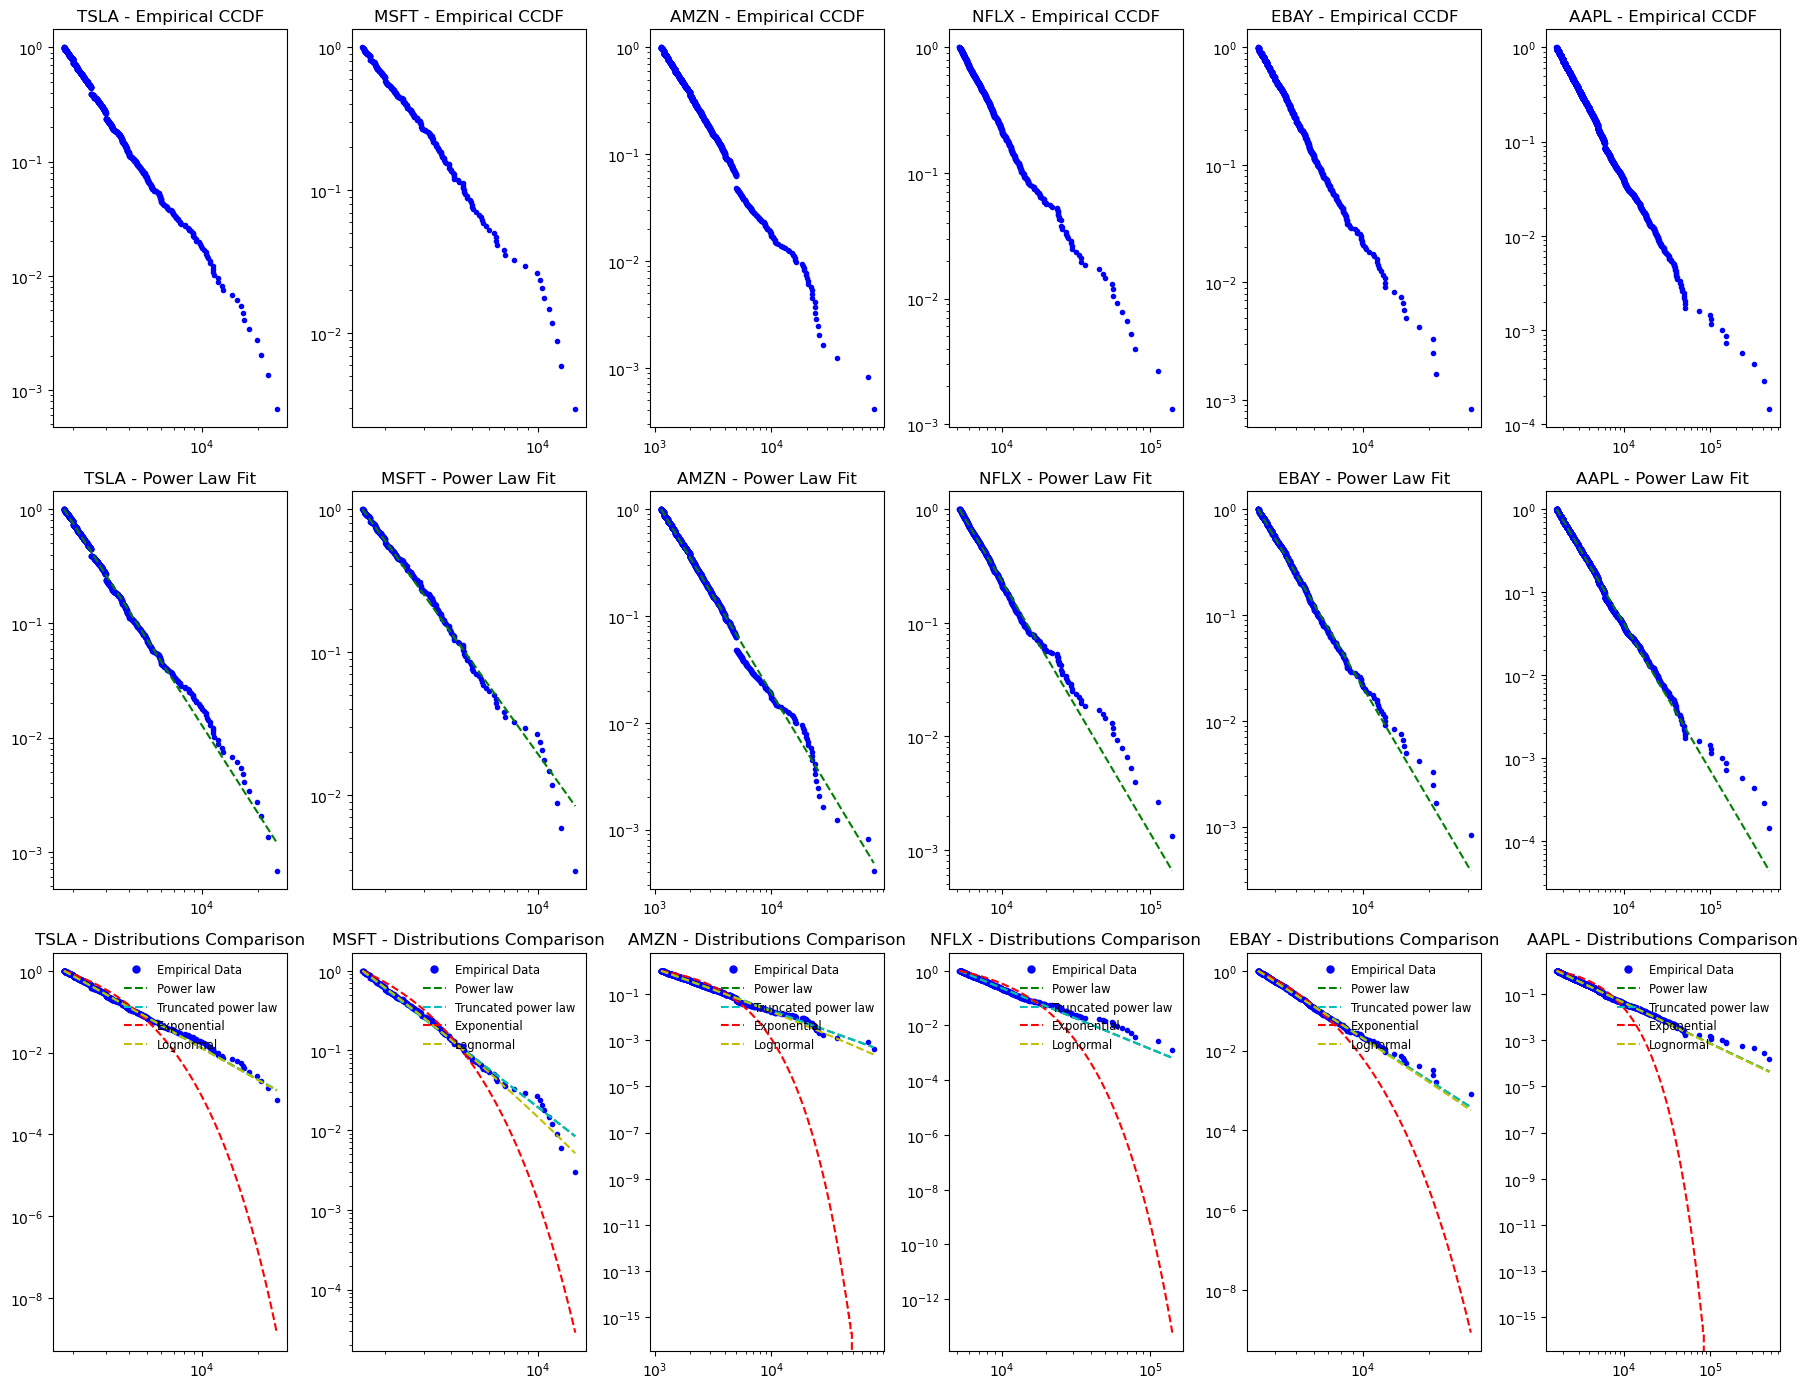

In [11]:
# Plot fitted objects
plot_fit_objects(volume_fit_objects)

#### 1.2.1 Retrieve Power law fitting results

In [12]:
# Get power_law fitting parameters for specific distribution across all stocks
volume_fit_results = get_fitting_params(volume_fit_objects, 'power_law')
print(volume_fit_results)

  Stock Distribution     alpha    xmin  KS Distance
0  TSLA    power_law  3.533354  1783.0     0.033694
1  MSFT    power_law  3.127830  1569.0     0.031072
2  AMZN    power_law  2.818538  1133.0     0.026184
3  NFLX    power_law  3.219314  5189.0     0.021056
4  EBAY    power_law  4.555286  3366.0     0.026187
5  AAPL    power_law  2.773512  1671.0     0.016872


In [13]:
# Average Alpha exponents across stocks
min_alpha = volume_fit_results['alpha'].min()
max_alpha = volume_fit_results['alpha'].max()
avg_alpha = volume_fit_results['alpha'].mean()
std_dev_alpha = volume_fit_results['alpha'].std()

print(f"Min Alpha: {min_alpha}")
print(f"Max Alpha: {max_alpha}")
print(f"Average Alpha: {avg_alpha}")
print(f"std_dev_alpha: {std_dev_alpha}")

Min Alpha: 2.77351157300678
Max Alpha: 4.555285506706385
Average Alpha: 3.3379723140585917
std_dev_alpha: 0.6582845952519403


In [14]:
# Get truncated_power_law fitting parameters for specific distribution across all stocks
volume_fit_results = get_fitting_params(volume_fit_objects, 'truncated_power_law')
print(volume_fit_results)

  Stock         Distribution     alpha        Lambda    xmin  KS Distance
0  TSLA  truncated_power_law  3.516018  3.617266e-06  1783.0     0.034369
1  MSFT  truncated_power_law  2.790038  7.468941e-05  1569.0     0.036518
2  AMZN  truncated_power_law  2.774251  9.212316e-06  1133.0     0.024822
3  NFLX  truncated_power_law  3.219390  1.405569e-11  5189.0     0.021049
4  EBAY  truncated_power_law  4.530306  3.852659e-06  3366.0     0.027242
5  AAPL  truncated_power_law  2.773512  5.421011e-20  1671.0     0.016872


In [15]:
# Get exponential distribution fitting parameters for specific distribution across all stocks
volume_fit_results = get_fitting_params(volume_fit_objects, 'exponential')
print(volume_fit_results)

  Stock Distribution    Lambda    xmin  KS Distance
0  TSLA  exponential  0.000865  1783.0     0.146754
1  MSFT  exponential  0.000787  1569.0     0.138159
2  AMZN  exponential  0.000766  1133.0     0.163190
3  NFLX  exponential  0.000224  5189.0     0.161499
4  EBAY  exponential  0.000761  3366.0     0.082773
5  AAPL  exponential  0.000444  1671.0     0.208895


#### 1.2.2. Compare alternative distributions

In [16]:
# Compare against alternative heavy-tailed distributions
from IPython.display import display
volume_comparison = distribution_compare(volume_fit_objects, 'exponential')
display(volume_comparison)

,Stock,Alternative Distribution,Lambda,xmin,Power Law Alpha,KS Distance (Power Law),KS Distance (exponential),Loglikelihood Ratio,p-value
0,TSLA,exponential,0.000865,1783.0,3.533354,0.033694,0.146754,5.580475,2.398629e-08
1,MSFT,exponential,0.000787,1569.0,3.127830,0.031072,0.138159,2.744876,6.053379e-03
2,AMZN,exponential,0.000766,1133.0,2.818538,0.026184,0.163190,5.981300,2.213631e-09
3,NFLX,exponential,0.000224,5189.0,3.219314,0.021056,0.161499,4.628210,3.688408e-06
4,EBAY,exponential,0.000761,3366.0,4.555286,0.026187,0.082773,3.229021,1.242149e-03
5,AAPL,exponential,0.000444,1671.0,2.773512,0.016872,0.208895,6.437601,1.213763e-10


## 2. Signed Ordeflow Imbalance

In [17]:
# Aggregate orderflow
tsla_aggregate_orderflow = compute_aggregate_features(tsla_raw_df, [T])
msft_aggregate_orderflow = compute_aggregate_features(msft_raw_df, [T])
amzn_aggregate_orderflow = compute_aggregate_features(amzn_raw_df, [T])
nflx_aggregate_orderflow = compute_aggregate_features(nflx_raw_df, [T])
ebay_aggregate_orderflow = compute_aggregate_features(ebay_raw_df, [T])
appl_aggregate_orderflow = compute_aggregate_features(appl_raw_df, [T])

# Normalize imblances
tsla_aggregate_orderflow = normalize_imbalances(tsla_aggregate_orderflow)
msft_aggregate_orderflow = normalize_imbalances(msft_aggregate_orderflow)
amzn_aggregate_orderflow = normalize_imbalances(amzn_aggregate_orderflow)
nflx_aggregate_orderflow = normalize_imbalances(nflx_aggregate_orderflow)
ebay_aggregate_orderflow = normalize_imbalances(ebay_aggregate_orderflow)
appl_aggregate_orderflow = normalize_imbalances(appl_aggregate_orderflow)

# Order Sign imbalance
sign_imbalance = {
  'TSLA': tsla_aggregate_orderflow['sign_imbalance'],
  'MSFT': msft_aggregate_orderflow['sign_imbalance'],
  'AMZN': amzn_aggregate_orderflow['sign_imbalance'],
  'NFLX': nflx_aggregate_orderflow['sign_imbalance'],
  'EBAY': ebay_aggregate_orderflow['sign_imbalance'],
  'AAPL': appl_aggregate_orderflow['sign_imbalance']
}
# Update the dictionary to only keep the first EVENTS_RANGE items
#sign_imbalance = {stock: data.head(EVENTS_RANGE) for stock, data in sign_imbalance.items()}


# Sign Volume Imbalance
volume_imbalance = {
 'TSLA': tsla_aggregate_orderflow['volume_imbalance'],
 'MSFT': msft_aggregate_orderflow['volume_imbalance'],
 'AMZN': amzn_aggregate_orderflow['volume_imbalance'],
 'NFLX': nflx_aggregate_orderflow['volume_imbalance'],
 'EBAY': ebay_aggregate_orderflow['volume_imbalance'],
 'AAPL': appl_aggregate_orderflow['volume_imbalance']
}
#volume_imbalance = {stock: data.head(EVENTS_RANGE) for stock, data in volume_imbalance.items()}

### Stationarity Tests

In [18]:
# sign_imbalance ADF test
print('Order-sign Imbalance')
for stock, data in sign_imbalance.items():
    augmented_dickey_fuller(data.head(EVENTS_RANGE), stock)
print('\n')


Order-sign Imbalance
TSLA
ADF: -14.96
p-value: 0.00,
N: 1409, 
critical values: {'1%': -3.434999576596685, '5%': -2.8635934599975106, '10%': -2.5678632530961614}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


MSFT
ADF: -15.80
p-value: 0.00,
N: 1212, 
critical values: {'1%': -3.4357569339190457, '5%': -2.863927640806119, '10%': -2.5680412191887507}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


AMZN
ADF: -14.94
p-value: 0.00,
N: 1166, 
critical values: {'1%': -3.4359707158251345, '5%': -2.864021955976527, '10%': -2.568091448619991}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


NFLX
ADF: -12.85
p-value: 0.00,
N: 1275, 
critical values: {'1%': -3.4354892269437243, '5%': -2.863809525815561, '10%': -2.5679783161860823}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be st

In [19]:
# volume_imbalance ADF test
print('Signed-volume Imbalance')
for stock, data in volume_imbalance.items():
    augmented_dickey_fuller(data.head(EVENTS_RANGE), stock)

Signed-volume Imbalance
TSLA
ADF: -16.64
p-value: 0.00,
N: 1409, 
critical values: {'1%': -3.434999576596685, '5%': -2.8635934599975106, '10%': -2.5678632530961614}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


MSFT
ADF: -12.55
p-value: 0.00,
N: 1209, 
critical values: {'1%': -3.435770379276604, '5%': -2.8639335727551223, '10%': -2.5680443783356286}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


AMZN
ADF: -17.95
p-value: 0.00,
N: 1168, 
critical values: {'1%': -3.4359610700352032, '5%': -2.8640177006421395, '10%': -2.568089182333693}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


NFLX
ADF: -11.50
p-value: 0.00,
N: 1273, 
critical values: {'1%': -3.435497317510684, '5%': -2.8638130956084464, '10%': -2.5679802172809003}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to b

### 2.1. Order Sign Imbalance

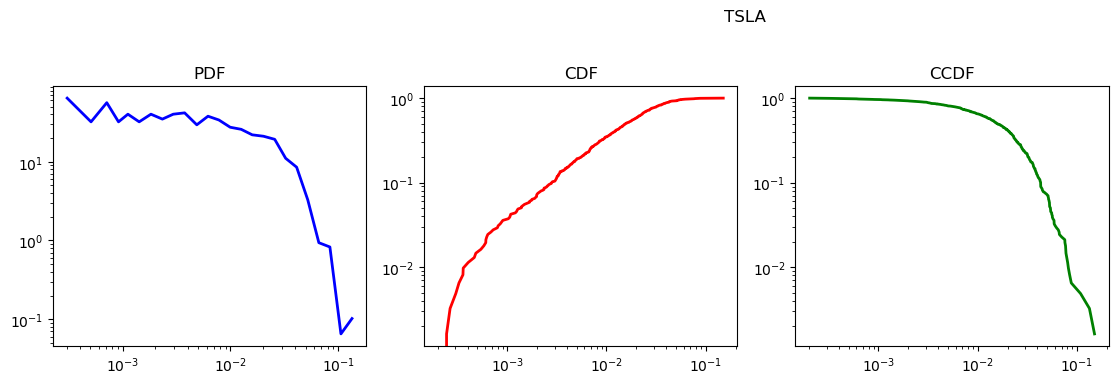

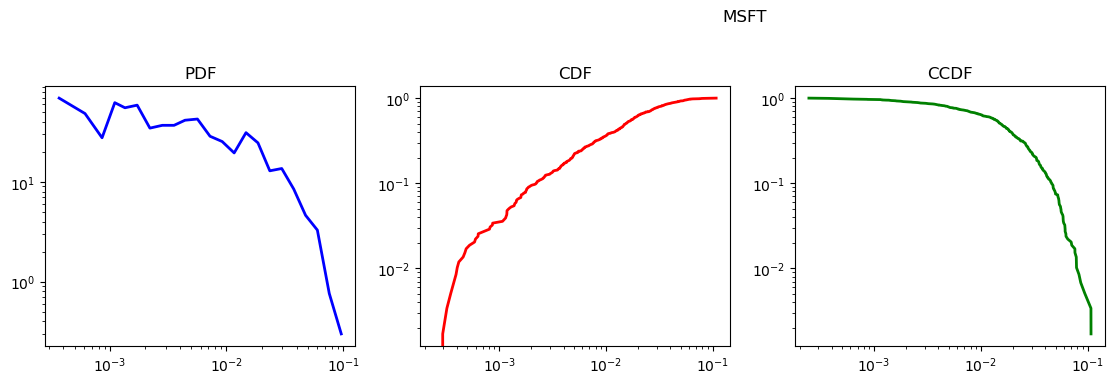

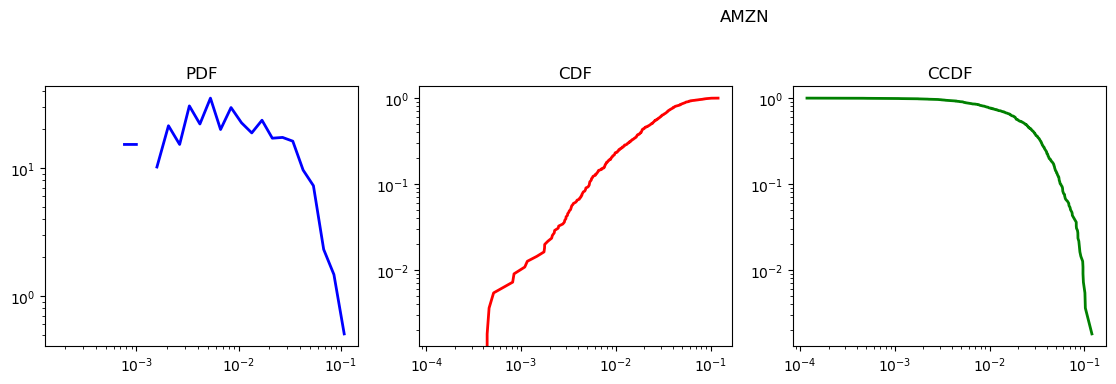

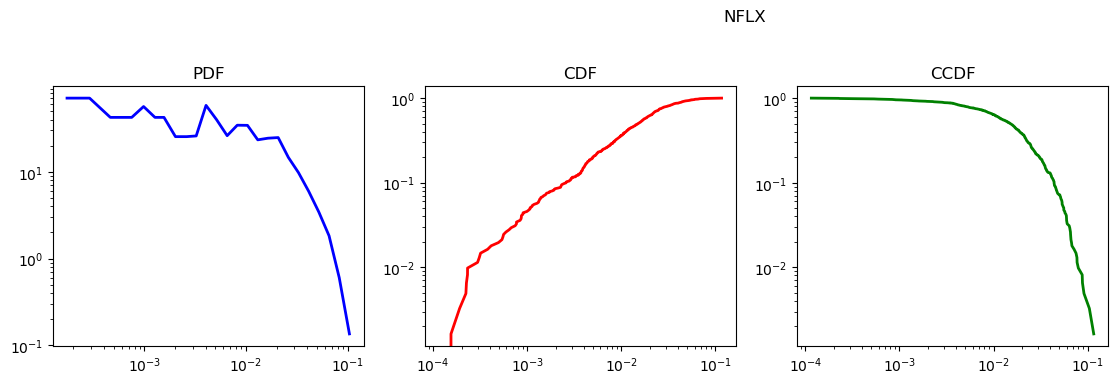

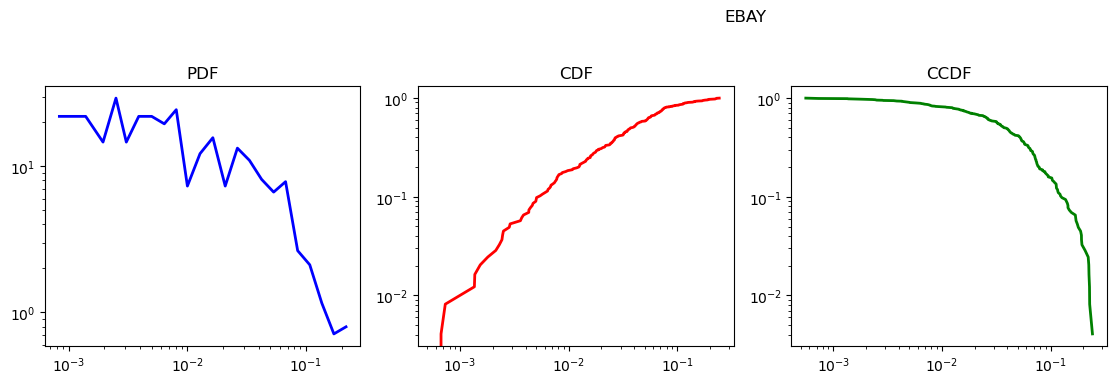

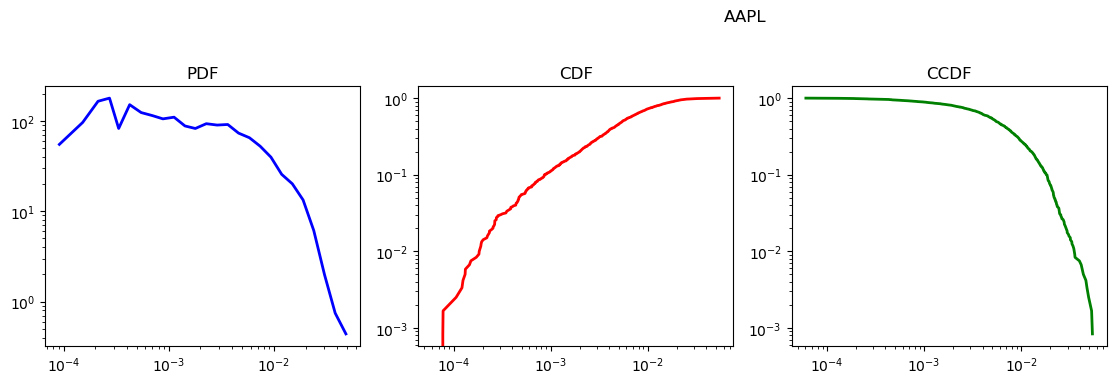

In [20]:
# Plot distribution of sign_imbalance for each stock
for stock_name, data in sign_imbalance.items():
    plot_distributions(stock_name, data)

#### 2.1.1. Fit power law distribution

In [21]:
# 1. Fit Powerlaw and retrieve fitted object/ results
sign_imbalance_data = os.path.join(root_dir, 'data', 'generated', 'mo_data', 'distributions', 'mo_sign_imbalance_distributions.pkl')

# If the file doesn't exist, fit the series and save the results.
if not os.path.exists(sign_imbalance_data):
    sign_imbalance_fit_objects = fit_powerlaw(data_dict=sign_imbalance, filename=sign_imbalance_data)
else:
    sign_imbalance_fit_objects = load_fit_objects(sign_imbalance_data)

sign_imbalance_fit_objects

Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


{'TSLA': <powerlaw.Fit at 0x14d793350>,
 'MSFT': <powerlaw.Fit at 0x14fe0df10>,
 'AMZN': <powerlaw.Fit at 0x14fe0c9d0>,
 'NFLX': <powerlaw.Fit at 0x286b053d0>,
 'EBAY': <powerlaw.Fit at 0x286b05b90>,
 'AAPL': <powerlaw.Fit at 0x286b06650>}

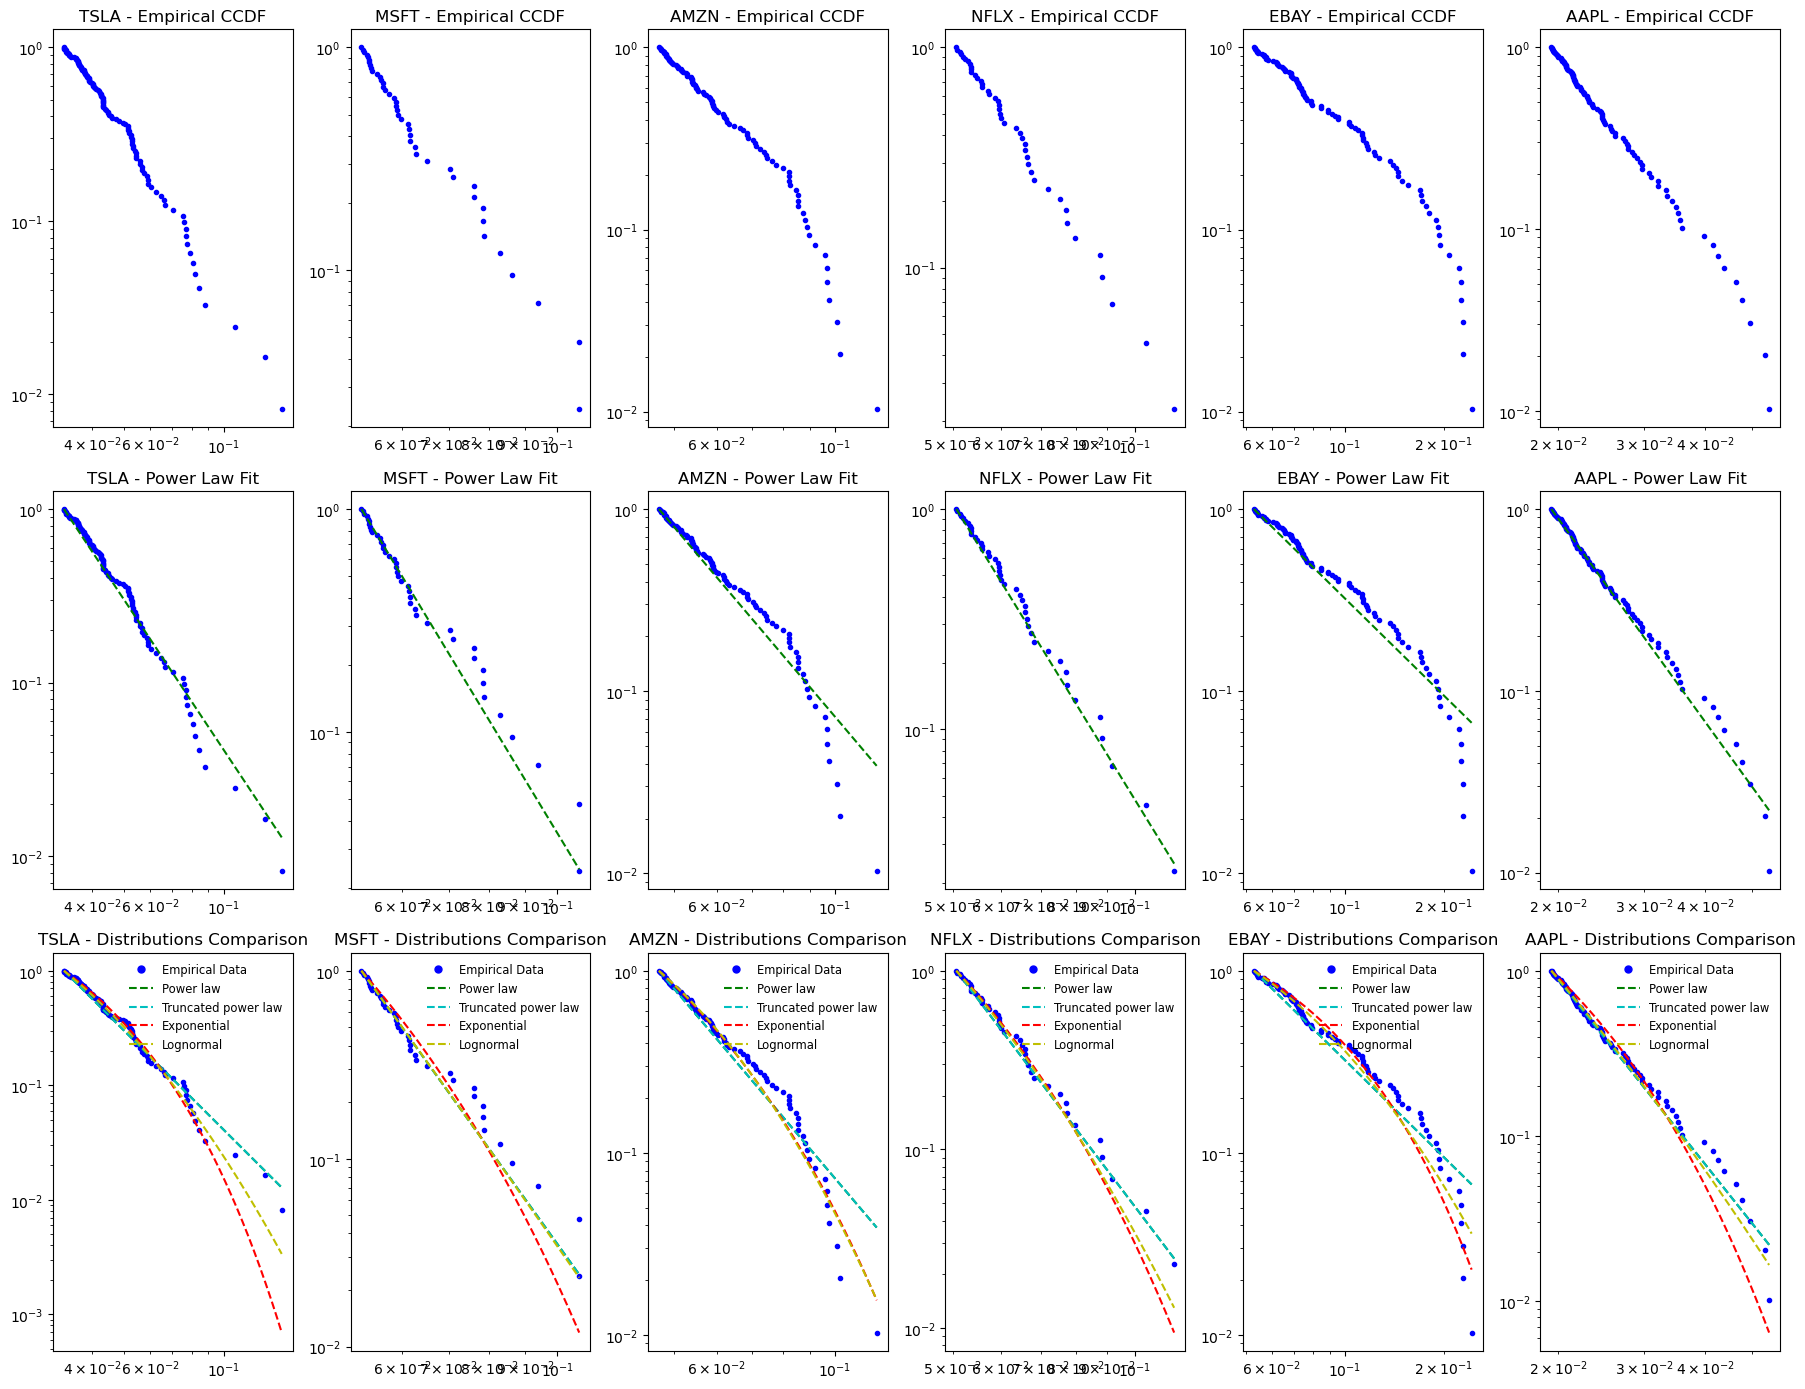

In [22]:
# Plot fitted objects
plot_fit_objects(sign_imbalance_fit_objects)

#### 2.1.2. Retrieve Power law fitting results

In [23]:
# Get fitting parameters for specific distribution across all stocks
sign_imbalance_fit_results = get_fitting_params(sign_imbalance_fit_objects, 'power_law')
print(sign_imbalance_fit_results)

  Stock Distribution     alpha      xmin  KS Distance
0  TSLA    power_law  3.863469  0.032782     0.078163
1  MSFT    power_law  6.183551  0.052456     0.091198
2  AMZN    power_law  4.447378  0.046756     0.070462
3  NFLX    power_law  5.467681  0.050713     0.078084
4  EBAY    power_law  2.768604  0.052840     0.088346
5  AAPL    power_law  4.711709  0.019351     0.030713


In [24]:
# Average Alpha exponents across stocks
min_alpha = sign_imbalance_fit_results['alpha'].min()
max_alpha = sign_imbalance_fit_results['alpha'].max()
avg_alpha = sign_imbalance_fit_results['alpha'].mean()
std_dev_alpha = sign_imbalance_fit_results['alpha'].std()

print(f"Min Alpha: {min_alpha}")
print(f"Max Alpha: {max_alpha}")
print(f"Average Alpha: {avg_alpha}")
print(f"std_dev_alpha: {std_dev_alpha}")

Min Alpha: 2.768603650056683
Max Alpha: 6.183550760551467
Average Alpha: 4.5737317989994795
std_dev_alpha: 1.199051770345961


In [25]:
# Get fitting parameters for specific distribution across all stocks
sign_imbalance_fit_results = get_fitting_params(sign_imbalance_fit_objects, 'truncated_power_law')
print(sign_imbalance_fit_results)

  Stock         Distribution     alpha     Lambda      xmin  KS Distance
0  TSLA  truncated_power_law  1.951732  29.761599  0.032782     0.052934
1  MSFT  truncated_power_law  5.339848  10.686987  0.052456     0.090602
2  AMZN  truncated_power_law  1.000000  43.910677  0.046756     0.070264
3  NFLX  truncated_power_law  1.521924  50.929310  0.050713     0.045630
4  EBAY  truncated_power_law  1.000000  12.254451  0.052840     0.074558
5  AAPL  truncated_power_law  3.415575  38.518047  0.019351     0.039743


In [26]:
# Get fitting parameters for specific distribution across all stocks
sign_imbalance_exp_results = get_fitting_params(sign_imbalance_fit_objects, 'exponential')
print(sign_imbalance_exp_results)

  Stock Distribution      Lambda      xmin  KS Distance
0  TSLA  exponential   61.942786  0.032782     0.073211
1  MSFT  exponential   80.482782  0.052456     0.104285
2  AMZN  exponential   56.966900  0.046756     0.071390
3  NFLX  exponential   71.098236  0.050713     0.041372
4  EBAY  exponential   19.826898  0.052840     0.110277
5  AAPL  exponential  144.984302  0.019351     0.080969


#### 2.1.3. Compare alternative distributions

In [27]:
# Compare against alternative heavy-tailed distributions
from IPython.display import display
sign_imbalance_comparison = distribution_compare(sign_imbalance_fit_objects, 'exponential')
display(sign_imbalance_comparison)

,Stock,Alternative Distribution,Lambda,xmin,Power Law Alpha,KS Distance (Power Law),KS Distance (exponential),Loglikelihood Ratio,p-value
0,TSLA,exponential,61.942786,0.032782,3.863469,0.078163,0.073211,-0.218746,0.826848
1,MSFT,exponential,80.482782,0.052456,6.183551,0.091198,0.104285,0.604218,0.545698
2,AMZN,exponential,56.966900,0.046756,4.447378,0.070462,0.071390,-1.971973,0.048613
3,NFLX,exponential,71.098236,0.050713,5.467681,0.078084,0.041372,-0.448101,0.654081
4,EBAY,exponential,19.826898,0.052840,2.768604,0.088346,0.110277,-1.377232,0.168440
5,AAPL,exponential,144.984302,0.019351,4.711709,0.030713,0.080969,0.577694,0.563471


### 2.2. Volume Imbalance

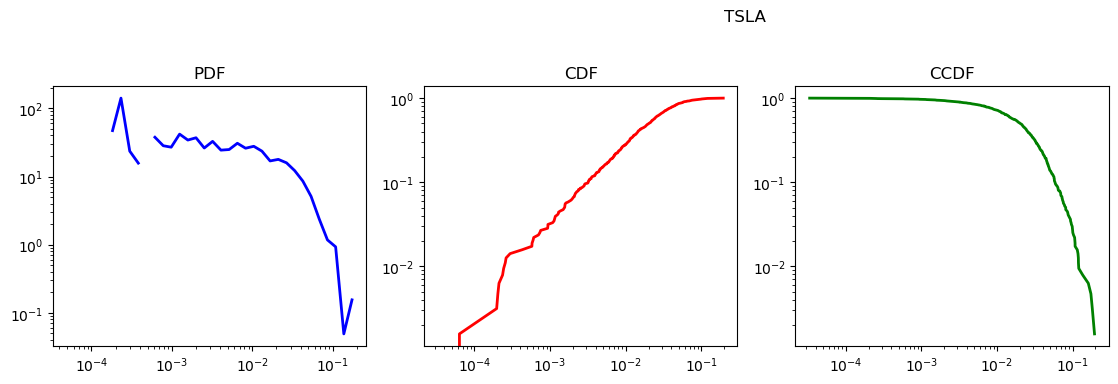

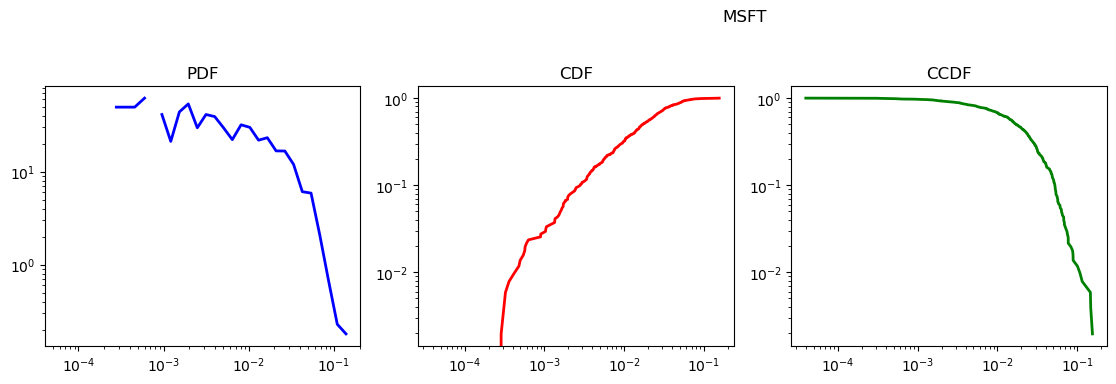

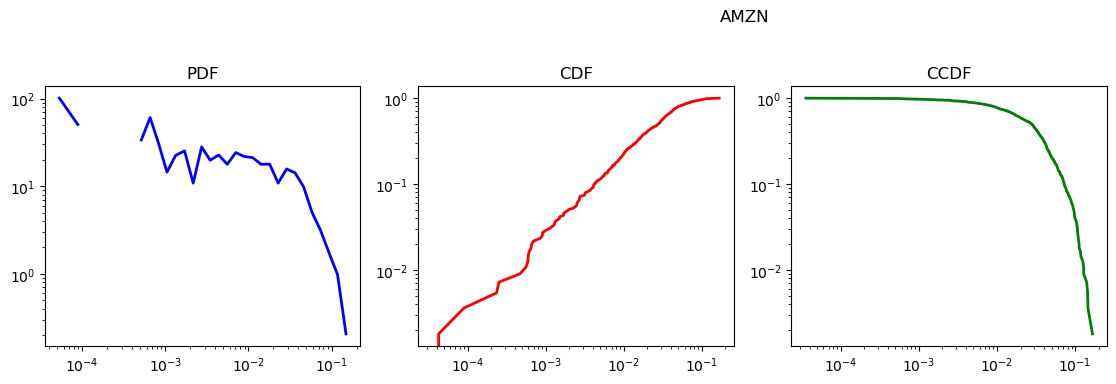

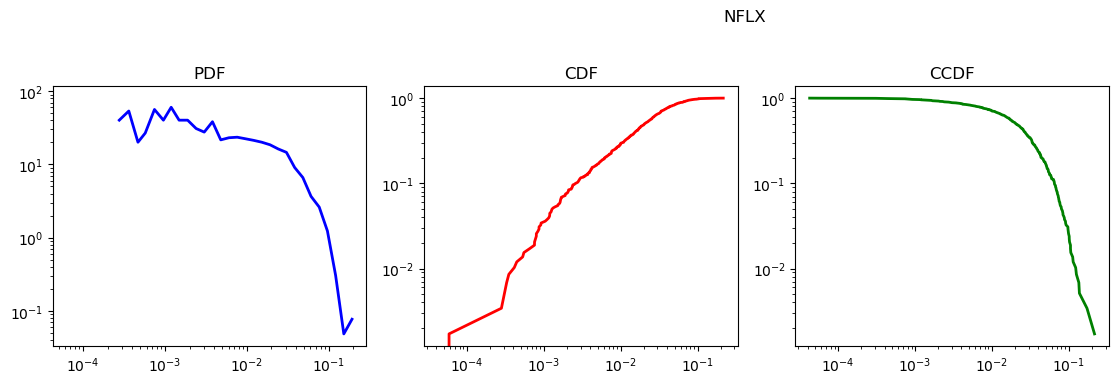

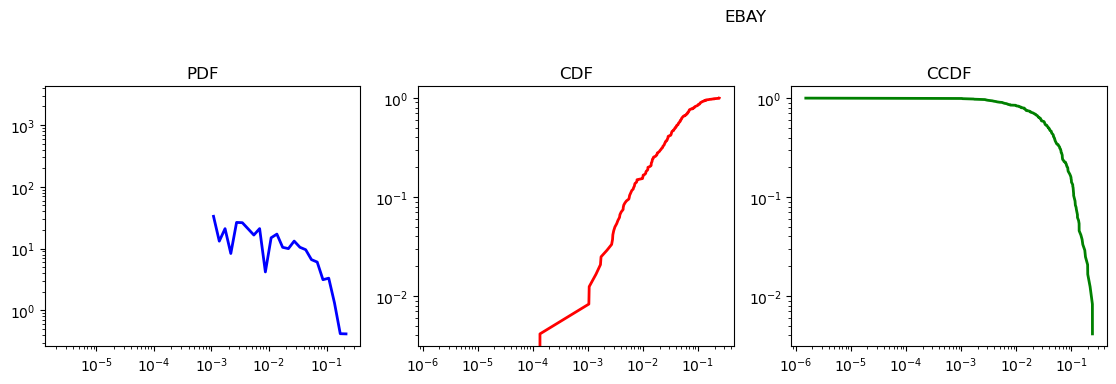

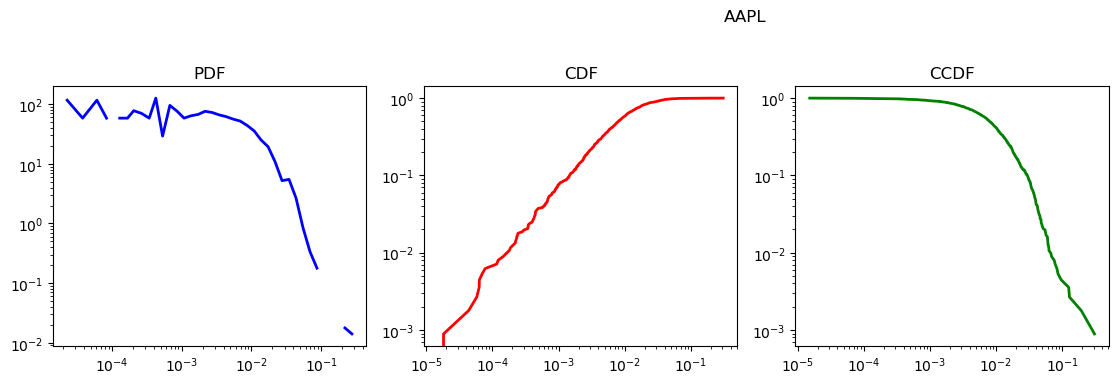

In [28]:
# Plot distribution of volume_imbalance for each stock
for stock_name, data in volume_imbalance.items():
    plot_distributions(stock_name, data)

#### 2.2.1. Fit power law distribution

In [29]:
# 1. Fit Powerlaw and retrieve fitted object/ results
volume_imbalance_data = os.path.join(root_dir, 'data', 'generated', 'mo_data', 'distributions', 'mo_volume_imbalance_distributions.pkl')

# If the file doesn't exist, fit the series and save the results.
if not os.path.exists(volume_imbalance_data):
    volume_imbalance_data_fit_objects = fit_powerlaw(data_dict=volume_imbalance, filename=volume_imbalance_data)
else:
    volume_imbalance_data_fit_objects = load_fit_objects(volume_imbalance_data)

volume_imbalance_data_fit_objects

Calculating best minimal value for power law fit


/Users/ana_bugaenko/.conda/envs/py311/lib/python3.11/site-packages/powerlaw.py:1151: RuntimeWarning: invalid value encountered in log
  self.alpha = 1 + (self.n / sum(log(data/self.xmin)))
/Users/ana_bugaenko/.conda/envs/py311/lib/python3.11/site-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in log
  return 1 + len(data)/sum(log(data / (self.xmin)))


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


{'TSLA': <powerlaw.Fit at 0x286aa0a50>,
 'MSFT': <powerlaw.Fit at 0x29878e110>,
 'AMZN': <powerlaw.Fit at 0x2984501d0>,
 'NFLX': <powerlaw.Fit at 0x29834cf50>,
 'EBAY': <powerlaw.Fit at 0x298481650>,
 'AAPL': <powerlaw.Fit at 0x29844a110>}

/Users/ana_bugaenko/.conda/envs/py311/lib/python3.11/site-packages/powerlaw.py:1615: RuntimeWarning: invalid value encountered in divide
  CDF = CDF/norm
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


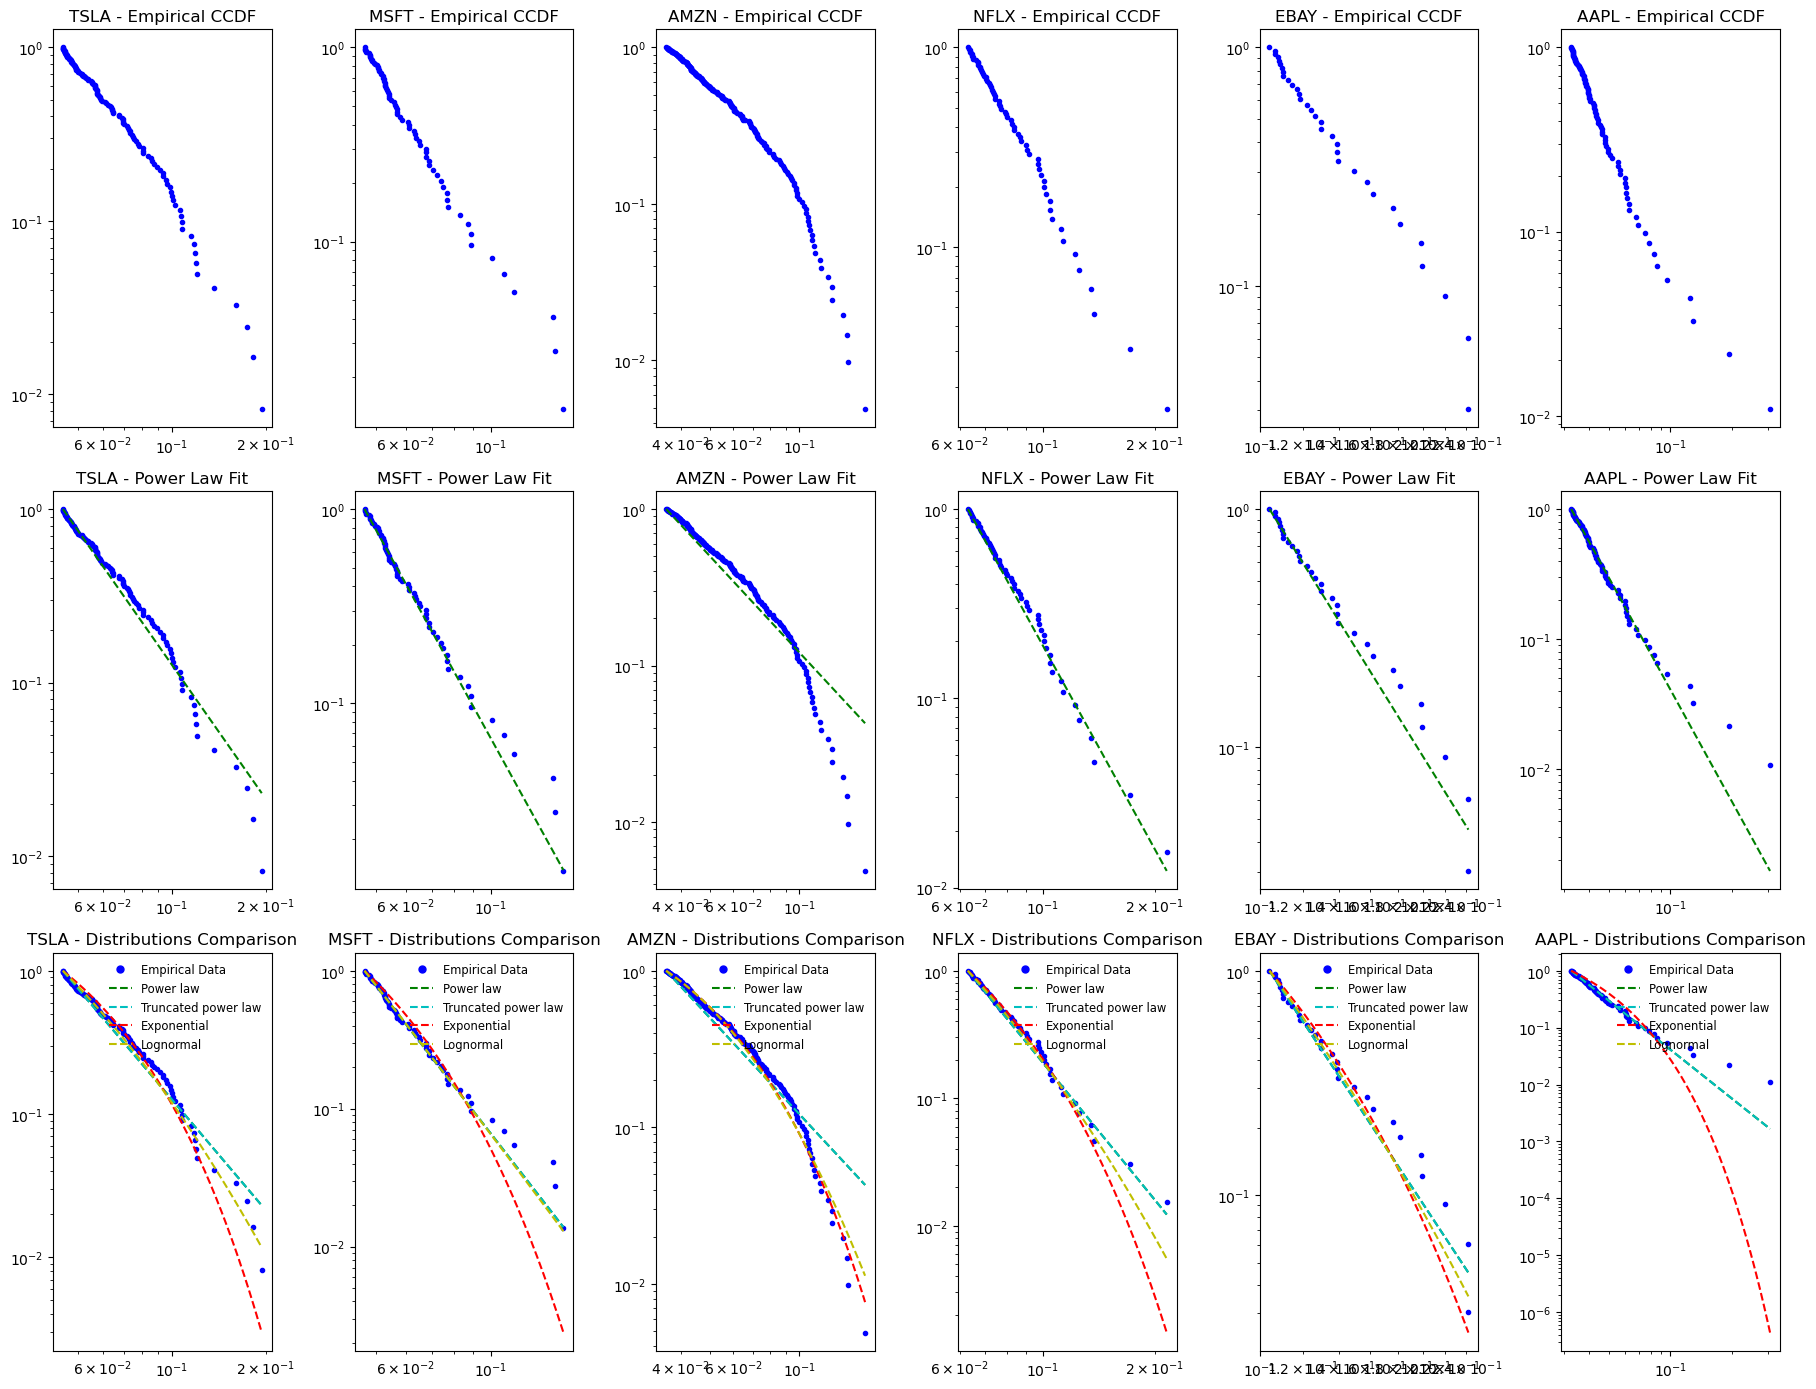

In [30]:
# Plot fitted objects
plot_fit_objects(volume_imbalance_data_fit_objects)

#### 2.2.2. Retrieve Power law fitting results

In [31]:
# Get fitting parameters for specific distribution across all stocks
volume_imbalance_fit_results = get_fitting_params(volume_imbalance_data_fit_objects, 'power_law')
print(volume_imbalance_fit_results)

  Stock Distribution     alpha      xmin  KS Distance
0  TSLA    power_law  3.561580  0.044597     0.066042
1  MSFT    power_law  4.575071  0.046762     0.045124
2  AMZN    power_law  3.042207  0.035668     0.082744
3  NFLX    power_law  4.581813  0.062973     0.063814
4  EBAY    power_law  4.666143  0.104298     0.066182
5  AAPL    power_law  3.855207  0.032662     0.033507


In [32]:
# Average Alpha exponents across stocks
min_alpha = volume_imbalance_fit_results['alpha'].min()
max_alpha = volume_imbalance_fit_results['alpha'].max()
avg_alpha = volume_imbalance_fit_results['alpha'].mean()
std_dev_alpha = volume_imbalance_fit_results['alpha'].std()

print(f"Min Alpha: {min_alpha}")
print(f"Max Alpha: {max_alpha}")
print(f"Average Alpha: {avg_alpha}")
print(f"std_dev_alpha: {std_dev_alpha}")

Min Alpha: 3.042206840039631
Max Alpha: 4.6661432555542115
Average Alpha: 4.047003480885651
std_dev_alpha: 0.6678695161439083


In [33]:
# Get fitting parameters for specific distribution across all stocks
volume_imbalance_fit_results = get_fitting_params(volume_imbalance_data_fit_objects, 'truncated_power_law')
print(volume_imbalance_fit_results)

  Stock         Distribution     alpha        Lambda      xmin  KS Distance
0  TSLA  truncated_power_law  2.105570  1.519295e+01  0.044597     0.057375
1  MSFT  truncated_power_law  4.252481  3.701840e+00  0.046762     0.048969
2  AMZN  truncated_power_law  1.000000  2.447639e+01  0.035668     0.043735
3  NFLX  truncated_power_law  2.759491  1.660990e+01  0.062973     0.055805
4  EBAY  truncated_power_law  2.491613  1.221581e+01  0.104298     0.067136
5  AAPL  truncated_power_law  3.855166  1.968468e-07  0.032662     0.033508


In [34]:
# Get fitting parameters for specific distribution across all stocks
volume_imbalance_fit_results = get_fitting_params(volume_imbalance_data_fit_objects, 'exponential')
print(volume_imbalance_fit_results)

  Stock Distribution     Lambda      xmin  KS Distance
0  TSLA  exponential  38.805616  0.044597     0.091970
1  MSFT  exponential  55.888495  0.046762     0.113118
2  AMZN  exponential  37.169613  0.035668     0.041308
3  NFLX  exponential  42.922474  0.062973     0.052757
4  EBAY  exponential  26.803253  0.104298     0.086132
5  AAPL  exponential  53.316655  0.032662     0.150265


#### 2.2.3. Compare alternative distributions

In [35]:
# Compare against alternative heavy-tailed distributions
from IPython.display import display
volume_imbalance_comparison = distribution_compare(volume_imbalance_data_fit_objects, 'exponential')
display(volume_imbalance_comparison)

,Stock,Alternative Distribution,Lambda,xmin,Power Law Alpha,KS Distance (Power Law),KS Distance (exponential),Loglikelihood Ratio,p-value
0,TSLA,exponential,38.805616,0.044597,3.561580,0.066042,0.091970,0.070002,0.944192
1,MSFT,exponential,55.888495,0.046762,4.575071,0.045124,0.113118,1.219988,0.222469
2,AMZN,exponential,37.169613,0.035668,3.042207,0.082744,0.041308,-3.235976,0.001212
3,NFLX,exponential,42.922474,0.062973,4.581813,0.063814,0.052757,0.081252,0.935241
4,EBAY,exponential,26.803253,0.104298,4.666143,0.066182,0.086132,-0.058310,0.953502
5,AAPL,exponential,53.316655,0.032662,3.855207,0.033507,0.150265,1.815604,0.069431
